In [ ]:
import warnings

import astropy.units
import FunctionLib as FL
import inspect
from tqdm import tqdm
import astropy
import wave
from matplotlib.image import resample
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import re
import scipy

mpl.rcParams['font.family'] = 'serif'


warnings.filterwarnings("ignore")

DJAv4Catalog = FL.Spectrum_Catalog()
DJAv4Catalog.load_from_pkl(os.path.expanduser(
    '~/DustCurve/spectrum_catalog.pkl'))

beta = list()
halpha = list()
hbeta = list()
ids_subids = list()
i = 0
for id_subid, catalog in tqdm(DJAv4Catalog.catalog_iterator()):
    if not catalog.get('prism_filepath'):
        continue
    if catalog.get('file_count') < 3:
        continue
    if catalog.get('prism_redshift') is None:
        continue

    if catalog['prism_redshift'] < 3.8:
        continue
    if catalog['prism_redshift'] > 6.5:
        continue

    spectrum = FL.Load_Spectrum_From_Fits(
        catalog['prism_filepath'], redshift=catalog['prism_redshift'])

    # fit continuum
    spectrum.set_boundarys(1268*astropy.units.Angstrom,
                           2580*astropy.units.Angstrom)
    Fitter = FL.SpectralLineFitter(spectrum, 4863*astropy.units.Angstrom)
    exp_fit_result = Fitter.fit_power_law()
    if exp_fit_result.get('success') is not True:
        print('Failed to fit power law for', id_subid)
        continue

    #initialize emission line fluxes

    halpha_flux = None
    hbeta_flux = None

    HalphaFitter = None
    HbetaFitter = None


    # fit emission lines
    for available_filter in catalog['available_filters']:

        if available_filter == 'prism-clear':
            continue

        try:
            # Halpha
            spectrum = FL.Load_Spectrum_From_Fits(
                catalog['grating_filepaths'][available_filter], redshift=catalog['prism_redshift'])
            Halpha_restframe_wavelength = 6565*astropy.units.Angstrom
            spectrum.set_boundarys(
                6500*astropy.units.Angstrom, 6600*astropy.units.Angstrom)
            if spectrum.processing_wavelengths.data.size < 10:
                continue
            if np.mean(spectrum.processing_flux.data)<1e-25:
                continue
            #find the second maximum in the spectrum
            HalphaFitter = FL.SpectralLineFitter(
                spectrum, Halpha_restframe_wavelength)

            initial_guess_index = np.argmin(
                np.abs(spectrum.processing_wavelengths.data-6565))

            initial_guess = [spectrum.processing_flux.data[initial_guess_index],
                             spectrum.processing_wavelengths.data[initial_guess_index], 2, np.mean(spectrum.processing_flux.data)]

            halpha_fit_result = HalphaFitter.fit_single_gaussian_with_offset(
                initial_guess)

            if halpha_fit_result.get('success') is not True:
                continue
            if halpha_fit_result['fitted_curve'].data.mean()<1e-25:
                continue

            if np.sort(halpha_fit_result['fitted_curve'].data)[-1] < 1.2* np.sort(spectrum.processing_flux.data)[-2]:
                continue
            if halpha_fit_result['parameters']['stddev'] > 2 * astropy.units.Angstrom:
                continue
            if halpha_fit_result['parameters']['amplitude'] <= 1e-19 * astropy.units.erg / astropy.units.cm**2 / astropy.units.s / astropy.units.Angstrom:
                continue
            if HalphaFitter.check_line(Halpha_restframe_wavelength, halpha_fit_result['parameters']['mean']):
                halpha_flux = halpha_fit_result['integrated_flux']

        except Exception as e:
            # print('Failed to fit Halpha for', id_subid, e)
            continue

        try:
            # Hbeta
            spectrum = FL.Load_Spectrum_From_Fits(
                catalog['grating_filepaths'][available_filter], redshift=catalog['prism_redshift'])
            Hbeta_restframe_wavelength = 4863*astropy.units.Angstrom
            spectrum.set_boundarys(
                4800*astropy.units.Angstrom, 4900*astropy.units.Angstrom)
            if spectrum.processing_wavelengths.data.size < 10:
                continue
            if np.mean(spectrum.processing_flux.data)<1e-25:
                continue
            if np.max(spectrum.processing_flux.data) <5*np.mean(spectrum.processing_flux.data):
                continue
            HbetaFitter = FL.SpectralLineFitter(
                spectrum, Hbeta_restframe_wavelength)

            initial_guess_index = np.argmin(
                np.abs(spectrum.processing_wavelengths.data-4863))

            initial_guess = [spectrum.processing_flux.data[initial_guess_index],
                             spectrum.processing_wavelengths.data[initial_guess_index], 2, np.mean(spectrum.processing_flux.data)]

            hbeta_fit_result = HbetaFitter.fit_single_gaussian_with_offset(
                initial_guess)

            if hbeta_fit_result.get('success') is not True:
                continue
            if halpha_fit_result['fitted_curve'].data.max()<1e-20:
                continue
            if np.sort(hbeta_fit_result['fitted_curve'].data)[-1] < 1.2* np.sort(spectrum.processing_flux.data)[-2]:
                continue
            if hbeta_fit_result['parameters']['stddev'] > 4 * astropy.units.Angstrom:
                continue
            if hbeta_fit_result['parameters']['amplitude'] <= 1e-20 * astropy.units.erg / astropy.units.cm**2 / astropy.units.s / astropy.units.Angstrom:
                continue

            if HbetaFitter.check_line(Hbeta_restframe_wavelength, hbeta_fit_result['parameters']['mean']):
                hbeta_flux = hbeta_fit_result['integrated_flux']

        except Exception as e:
            # print('Failed to fit Hbeta for', id_subid, e)
            continue



    if 'halpha_flux' in locals() and 'hbeta_flux' in locals():
        if halpha_flux is None or hbeta_flux is None:
            continue
        beta.append(exp_fit_result['parameters']['decay'])
        halpha.append(halpha_flux.to('erg / (cm2 s)').value)
        hbeta.append(hbeta_flux.to('erg / (cm2 s)').value)
        ids_subids.append(id_subid)
        # print(halpha_flux.to('erg / (cm2 s)').value)
        # print(hbeta_flux.to('erg / (cm2 s)').value)
        # print('ID:', id_subid, 'Beta:', exp_fit_result['parameters']['decay'],
        #       'Halpha/Hbeta:', halpha_flux.to('erg / (cm2 s)').value/ hbeta_flux.to('erg / (cm2 s)').value)
        # print(halpha_fit_result['parameters']['stddev'], hbeta_fit_result['parameters']['stddev'])
        HalphaFitter.plot_fit_result(
            halpha_fit_result)
        HbetaFitter.plot_fit_result(
            hbeta_fit_result)

        i += 1
        if i > 300:
            break

In [ ]:
halpha_array = np.array(halpha)
hbeta_array = np.array(hbeta)
beta_array = np.array(beta)
ids_subids_array = np.array(ids_subids)

In [ ]:
beta_list = list()
halpha_list = list()
hbeta_list = list()
ids_subids_list = list()
for beta, halpha, hbeta, id_subid in zip(beta_array, halpha_array, hbeta_array, ids_subids_array):
    if hbeta <= 0 or halpha <= 0:
        continue
    balmer_ratio = halpha/hbeta/2.88
    if balmer_ratio < 0.001:
        continue
    if balmer_ratio > 10:
        continue
    beta_list.append(beta)
    halpha_list.append(halpha)
    hbeta_list.append(hbeta)
    ids_subids_list.append(id_subid)

beta_list = np.array(beta_list)
halpha_list = np.array(halpha_list)
hbeta_list = np.array(hbeta_list)
ids_subids_list = np.array(ids_subids_list)

In [ ]:
balmer = np.log10(halpha_list/hbeta_list/2.88)
plt.hist(balmer, bins=50, histtype='step', color='black', lw=2)

In [5]:
import warnings

import astropy.units
import FunctionLib as FL
import inspect
from tqdm import tqdm
import astropy
import wave
from matplotlib.image import resample
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import re
import scipy

mpl.rcParams['font.family'] = 'serif'


warnings.filterwarnings("ignore")
import random

def estimate_spectrum_noise(residual_spectrum, estimate_range=None, measure_window=10*astropy.units.Angstrom, measure_count=1000):
    if estimate_range is None:
        estimate_range = (residual_spectrum.processing_wavelengths.data.min(), residual_spectrum.processing_wavelengths.data.max())
    mask = (residual_spectrum.processing_wavelengths >= estimate_range[0]) & (
        residual_spectrum.processing_wavelengths <= estimate_range[1])
    flux_values = residual_spectrum.processing_flux.data[mask]

    for i in range(measure_count):
        measure_window_left = random.uniform(estimate_range[0].value, estimate_range[1].value - measure_window.value)
        measure_window_right = measure_window_left + measure_window.value

        measure_mask = (residual_spectrum.processing_wavelengths.data >= measure_window_left) & (
            residual_spectrum.processing_wavelengths.data <= measure_window_right)
        measure_flux = residual_spectrum.processing_flux.data[measure_mask]

        plt.figure(figsize=(10, 6))
        plt.plot(residual_spectrum.processing_wavelengths.data[mask], flux_values, color='black', lw=1)
        plt.axvline(measure_window_left, color='red', linestyle='--', lw=1)
        plt.axvline(measure_window_right, color='red', linestyle='--', lw=1)
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg / (cm2 s))')
        plt.title('Spectrum with Random Measure Window')
        plt.show()
        plt.close()


warnings.filterwarnings("ignore")

DJAv4Catalog = FL.Spectrum_Catalog()
DJAv4Catalog.load_from_pkl(os.path.expanduser(
    '~/DustCurve/spectrum_catalog.pkl'))

0it [00:00, ?it/s]

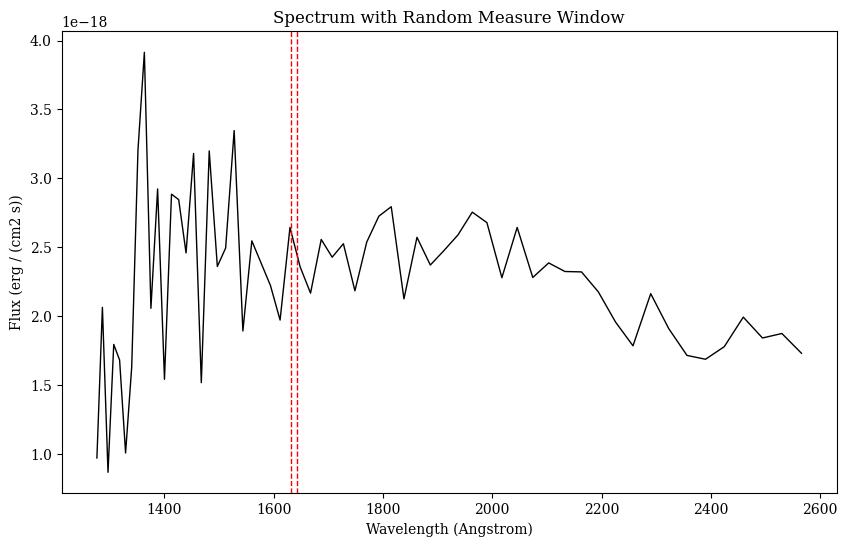

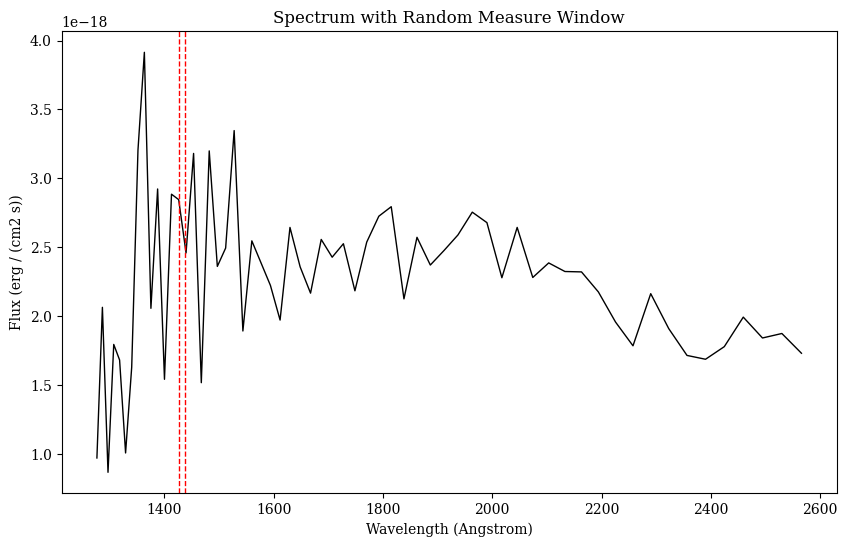

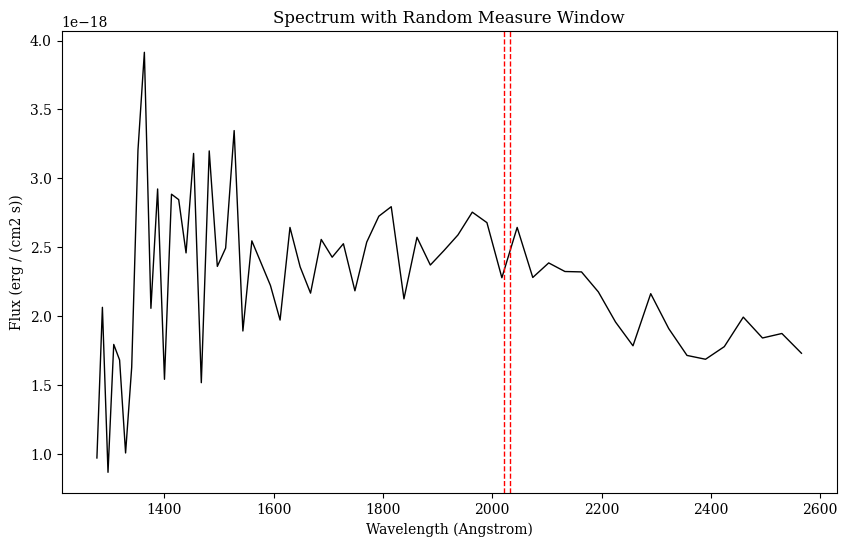

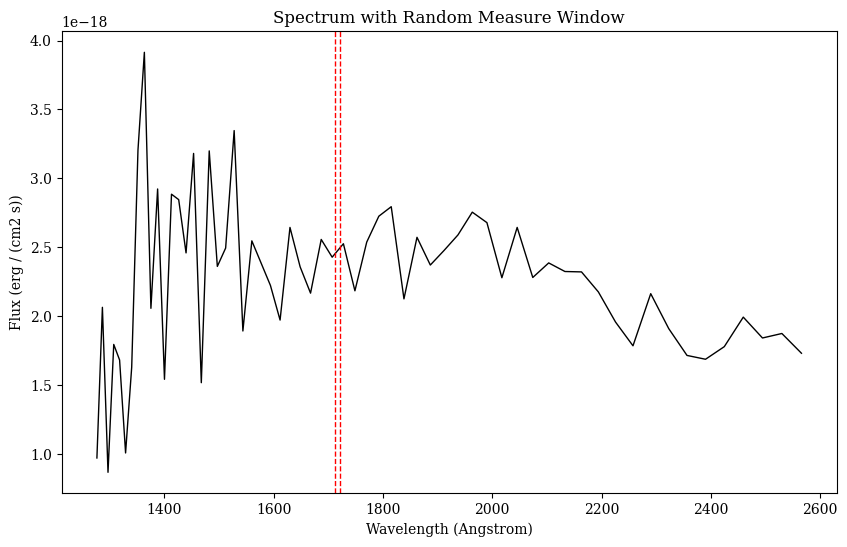

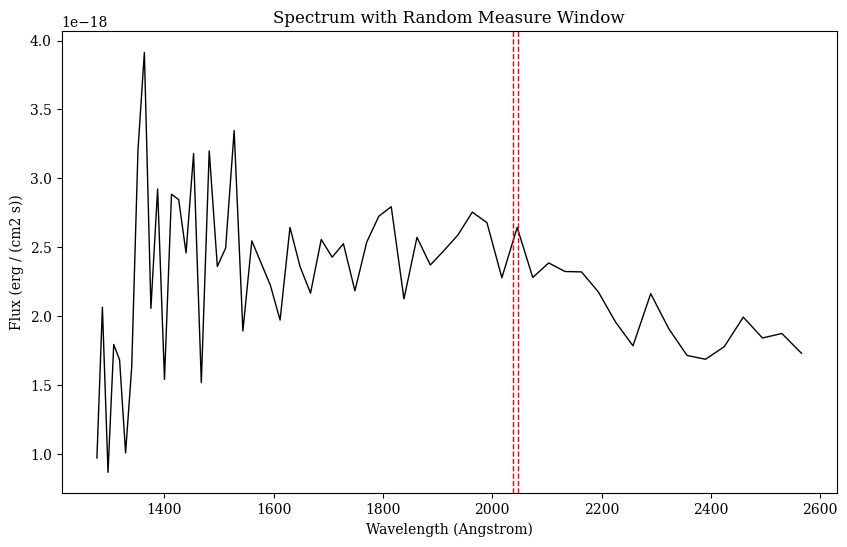

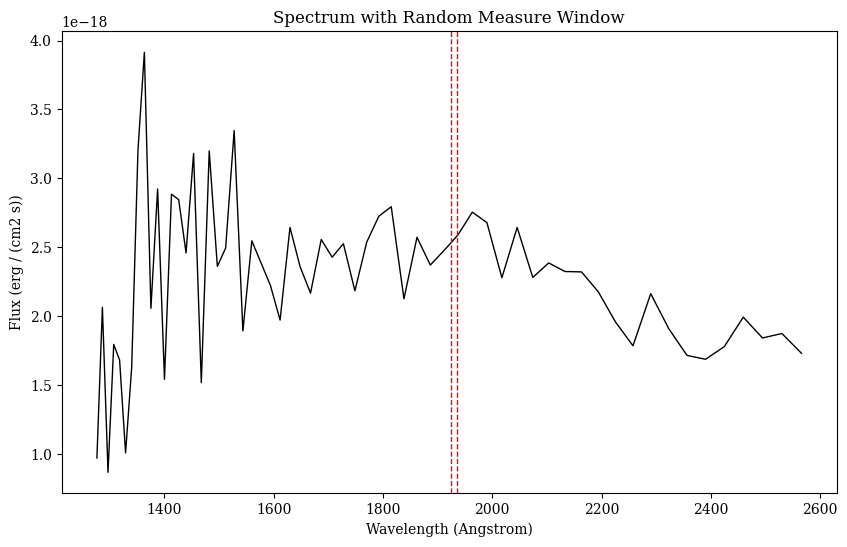

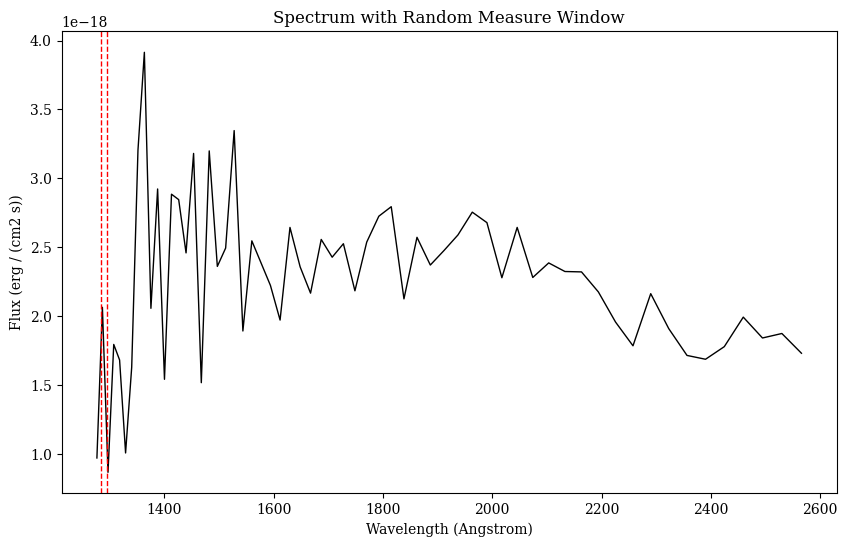

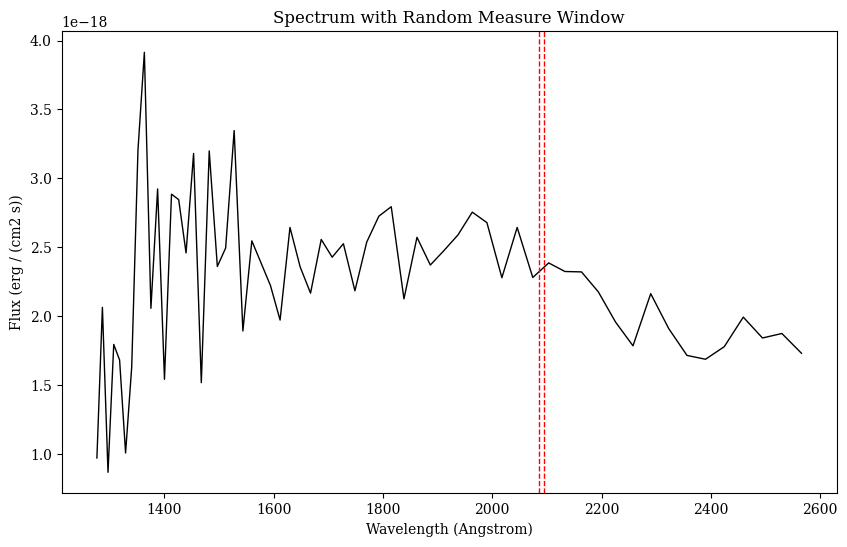

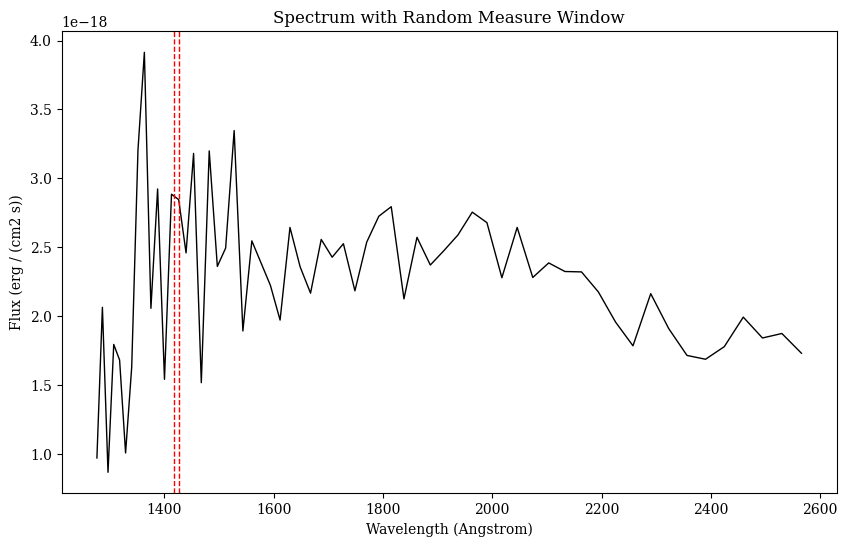

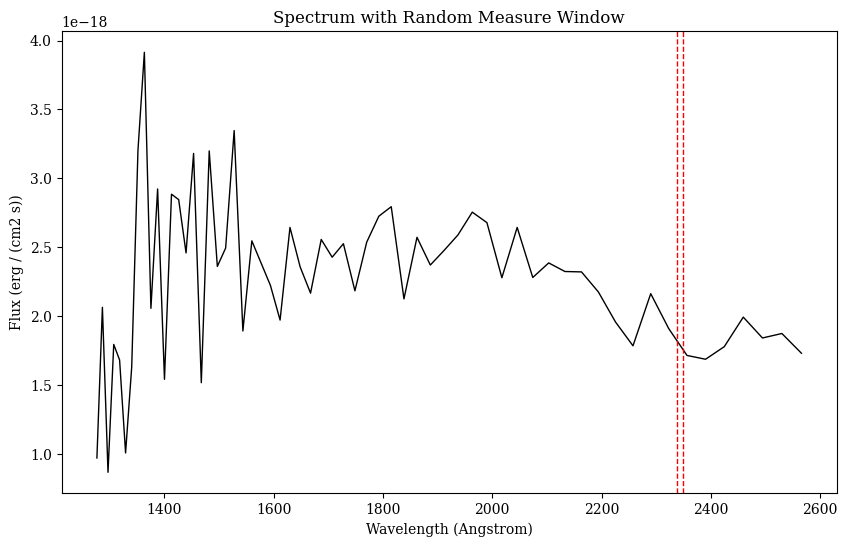

19it [00:01, 16.11it/s]


In [6]:
for id_subid, catalog in tqdm(DJAv4Catalog.catalog_iterator()):
    if not catalog.get('prism_filepath'):
        continue
    if catalog.get('file_count') < 3:
        continue
    if catalog.get('prism_redshift') is None:
        continue

    if catalog['prism_redshift'] < 3.8:
        continue
    if catalog['prism_redshift'] > 6.5:
        continue

    spectrum = FL.Load_Spectrum_From_Fits(
        catalog['prism_filepath'], redshift=catalog['prism_redshift'])

    estimate_spectrum_noise(spectrum, estimate_range=(1268*astropy.units.Angstrom, 2580*astropy.units.Angstrom), measure_window=10*astropy.units.Angstrom, measure_count=10)

    break